In [1]:
import numpy as np
from scipy.stats import chi2
from itertools import product
import warnings
import matplotlib.pyplot as plt
import time
import math
def gtest(X, Y, Z):
    """
    The G test can test for goodness of fit to a distribution.
    We are here testing the null hypothesis X \perp Y |Z
    Note X, Y, Z are all binary variables
    Parameters
    ----------
    X : array
    Y : array
    Z : n*d matrix with d number of conditioned variables
    ddof : int, optional
        adjustment to the degrees of freedom for the p-value
    Returns
    -------
    chisquare statistic : float
        The chisquare test statistic
    p : float
        The p-value of the test.
    Notes
    -----
    """
    assert len(X) == len(Y)
    n = Z.shape[1]
    df = 2**n
    EmpTable = np.zeros((2, 2, df))
    conditionedset = list(product([0, 1], repeat=n))
    for x in [0, 1]:
        for y in [0, 1]:
            for z in conditionedset:
                xindex = set(np.where(X == x)[0])
                yindex = set(np.where(Y == y)[0])
                valid_index = xindex.intersection(yindex)
                for i in range(len(z)):
                    valid_index = valid_index.intersection(set(np.where(Z[:,i] == z[i])[0]))
                ind = conditionedset.index(z)
                EmpTable[x, y, ind] = len(valid_index)
        
    ExpTable = np.zeros((2, 2, df))
    for x in [0, 1]:
        for y in [0, 1]:
            for z in range(len(conditionedset)):
                ExpTable[x, y, z] = np.sum(EmpTable[x, :, z])*np.sum(EmpTable[:, y, z])
                ExpTable[x, y, z] /= np.sum(EmpTable[:, :, z])
    prop = EmpTable.reshape(-1) * np.log((EmpTable/ExpTable).reshape(-1))
    prop = np.nan_to_num(prop)
    g = 2* np.sum(prop)
    sig = chi2.sf(g, df)
    return g, sig 

<ipython-input-1-0562a15b59e4>:51: RuntimeWarning: divide by zero encountered in log
  prop = EmpTable.reshape(-1) * np.log((EmpTable/ExpTable).reshape(-1))
<ipython-input-1-0562a15b59e4>:51: RuntimeWarning: invalid value encountered in multiply
  prop = EmpTable.reshape(-1) * np.log((EmpTable/ExpTable).reshape(-1))


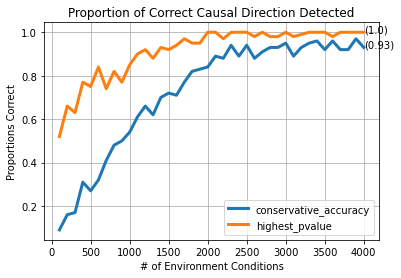

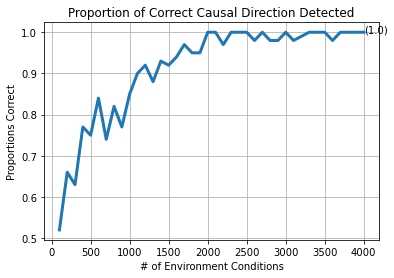

In [2]:
# 2 Env Multiple Samples, pooled data test
verbose = 0
env_range = range(100, 4100, 100)
sample_range = [2]
for ns in sample_range:
    CorrectXtoY = []
    BeliefXtoY = []
    times = []
    for ne in env_range:
        # print("Running experiment for environment number %d" %(ne))
        start_time = time.time()
        num_experiments = 100
        voteXtoY = []
        voteYtoX = []
        voteind = []
        for i in range(num_experiments):
            np.random.seed(i)
            num_env = ne
            num_sample = ns
            alpha_theta = 1
            beta_theta = 3
            alpha_psi = 1
            beta_psi = 3
            theta = np.random.beta(alpha_theta, beta_theta, num_env)
            psi = np.random.beta(alpha_psi, beta_psi, num_env)
            X = np.random.binomial(1, p = theta, size = (num_sample, num_env))
            psi_ind = np.random.binomial(1, p=psi, size = (num_sample, num_env))
            Y = (psi_ind != X).astype(int)
            XtoY_x = X[0,:]
            XtoY_y = Y[1,:]
            XtoY_z = X[1,:].reshape(-1,1)
            YtoX_x = Y[0,:]
            YtoX_y = X[1,:]
            YtoX_z = Y[1,:].reshape(-1,1)
            _, sigx = gtest(XtoY_x, XtoY_y, XtoY_z)
            _, sigy = gtest(YtoX_x, YtoX_y, YtoX_z)
            _, sig = gtest(XtoY_x, YtoX_x, np.matrix([]))
            voteXtoY.append(sigx)
            voteYtoX.append(sigy)
            voteind.append(sig)
        voteXtoY = np.array(voteXtoY)
        voteYtoX = np.array(voteYtoX)
        voteind = np.array(voteind)
        countsXtoY = np.sum( (voteXtoY >= 0.05)* (voteYtoX <= 0.05)*(voteind <= 0.05))
        countsYtoX = np.sum( (voteYtoX >= 0.05)* (voteXtoY <= 0.05)*(voteind <= 0.05))
        countsXY = np.sum( (voteind >= 0.05))
        countsUndecided = num_experiments - countsXtoY - countsYtoX - countsXY
        beliefs = np.argmax([voteXtoY, voteYtoX, voteind], axis = 0)
        CorrectXtoY.append(countsXtoY/num_experiments)
        BeliefXtoY.append(np.sum(beliefs == 0)/num_experiments)
        t = time.time() - start_time
        times.append(t)
        if verbose:
            print("\n VoteXtoY: %.4f" %(countsXtoY/num_experiments))
            print("\n VoteYtoX: %.4f" %(countsYtoX/num_experiments))
            print("\n VoteX Y: %.4f" %(countsXY/num_experiments))
            print("\n VoteUndecided: %.4f" %(countsUndecided/num_experiments))
            print("\n Belief XtoY: %.4f" %(np.sum(beliefs == 0)/num_experiments))
            print("\n Belief YtoX: %.4f" %(np.sum(beliefs == 1)/num_experiments))
            print("\n Belief X Y: %.4f" %(np.sum(beliefs == 2)/num_experiments))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(env_range, CorrectXtoY, linewidth = 3, label = "conservative_accuracy")
    ax.plot(env_range, BeliefXtoY, linewidth = 3, label = "highest_pvalue")
    # ax.plot(env_range, BeliefXtoY)
    ax.annotate('(%s)' %(BeliefXtoY[-1]), xy=(env_range[-1], BeliefXtoY[-1]), textcoords='data')
    ax.annotate('(%s)' %(CorrectXtoY[-1]), xy=(env_range[-1], CorrectXtoY[-1]), textcoords='data')
    ax.grid()
    ax.title.set_text("Proportion of Correct Causal Direction Detected")
    ax.set_xlabel("# of Environment Conditions")
    ax.set_ylabel("Proportions Correct")
    ax.legend()
    fig.savefig('binCDbase_comparison.jpg')
    plt.show()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #ax.plot(env_range, CorrectXtoY, linewidth = 3, label = "conservative_accuracy")
    ax.plot(env_range, BeliefXtoY, linewidth = 3, label = "highest_pvalue")
    # ax.plot(env_range, BeliefXtoY)
    ax.annotate('(%s)' %(BeliefXtoY[-1]), xy=(env_range[-1], BeliefXtoY[-1]), textcoords='data')
    #ax.annotate('(%s)' %(CorrectXtoY[-1]), xy=(env_range[-1], CorrectXtoY[-1]), textcoords='data')
    ax.grid()
    ax.title.set_text("Proportion of Correct Causal Direction Detected")
    ax.set_xlabel("# of Environment Conditions")
    ax.set_ylabel("Proportions Correct")
    plt.show()
    fig.savefig('binCDbase_highest_pvalue.jpg')